# A notebook that generates the inference for Pan-Nuke dataset

Reference:
- https://machinelearningspace.com/coco-dataset-a-step-by-step-guide-to-loading-and-visualizing/#step4

In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
import os
import sys
main_folder = '..'
if main_folder not in sys.path:
    sys.path.append(main_folder)

import numpy as np
import matplotlib.pyplot as plt
import torch
from mmdet.apis import init_detector, show_result_pyplot
from open_set.utils.eval.inference import inference_detector
import mmcv

from pycocotools.coco import COCO
from PIL import Image

In [11]:
# OVIS model
config_file = '../configs/demo/path_ground_baseline.py'
checkpoint_file = '../work_dirs/path_ground_baseline/epoch_50.pth'

In [12]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file)

/opt/conda/envs/betray/lib/python3.10/site-packages/mmdet/models/losses/cross_entropy_loss.py:239: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ../work_dirs/path_ground_baseline/epoch_50.pth
The model and loaded state dict do not match exactly

size mismatch for panoptic_fusion_head.novel_class_embs: copying a param with shape torch.Size([2, 768]) from checkpoint, the shape in current model is torch.Size([1, 768]).
size mismatch for panoptic_fusion_head.base_class_embs: copying a param with shape torch.Size([5, 768]) from checkpoint, the shape in current model is torch.Size([6, 768]).


In [14]:
classes = model.panoptic_fusion_head.ordered_class_names
print(classes)
print(len(classes))
CLASSES = []
for name in classes:
    CLASSES.append(name)
model.CLASSES = CLASSES

['connective', 'epithelial', 'neoplastic', 'inflammatory', 'dead']
5


In [15]:
val_coco = COCO("/jupyter-users-home/tan-2enguyen/datasets/pathology/anno_caption_merged/annotations_region_only/train_instances.json")
coco_captions = COCO('/jupyter-users-home/tan-2enguyen/datasets/pathology/anno_caption_merged/annotations_region_only/train_captions.json')

img_dir = "/jupyter-users-home/tan-2enguyen/datasets/pathology/anno_caption_merged/images"
image_id = 5

img = val_coco.imgs[image_id]

loading annotations into memory...
Done (t=1.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [16]:
cat_by_id = {}
for cat_id in val_coco.getCatIds():
    cat_by_id[cat_id] = val_coco.loadCats(cat_id)[0]['name']

{'license': 1, 'file_name': '5.jpg', 'coco_url': '', 'height': 256, 'width': 256, 'date_captured': '', 'flickr_url': '', 'organ': 'Breast', 'id': 5}
anno category ids = [1, 1, 1, 2, 2, 3, 3]
{1: 'neoplastic', 2: 'inflammatory', 3: 'connective', 4: 'dead', 5: 'epithelial', 6: 'background'}


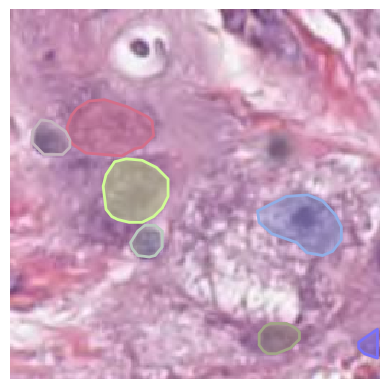

In [17]:
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')

# Get the ids of the captions
#caption_annotation_ids = coco_captions.getAnnIds(imgIds=image_id)
#print(caption_annotation_ids)
#captions = coco_captions.loadAnns(caption_annotation_ids)
print(img)
cat_ids = val_coco.getCatIds()
anns_ids = val_coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = val_coco.loadAnns(anns_ids)
val_coco.showAnns(anns, draw_bbox=False)
plt.axis(False)
print(f"anno category ids = {[x['category_id'] for x in anns]}")
print(cat_by_id)

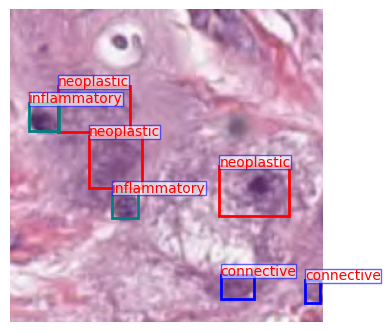

In [18]:
# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
for ann in anns:
    bbox = ann['bbox']
    x, y, w, h = [int(b) for b in bbox]
    class_id = ann["category_id"]
    class_name = val_coco.loadCats(class_id)[0]["name"]
    color_ = color_list[class_id]
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
    t_box=ax.text(x, y, class_name,  color='red', fontsize=10)
    t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
    ax.add_patch(rect)

ax.axis('off')
ax.imshow(image)
#ax[0,0].set_xlabel('Longitude')
plt.tight_layout()
plt.show()

In [25]:
# Predict segmentation results, as well as image captions
result = inference_detector(model, image, with_caption=True, logging=True)[0]

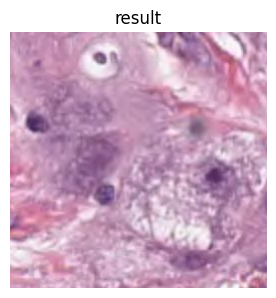

In [23]:
# show the results
show_result_pyplot(model, image, result, score_thr=0.5)

In [21]:
len(result['base_results'])

2

In [29]:
print(result['base_results'][0][0].shape)
print(result['base_results'][0][1].shape)
print(result['base_results'][0][2].shape)
print(result['base_results'][0][3].shape)

(81, 5)
(5, 5)
(14, 5)
(0, 5)


In [27]:
result['base_results'][0][1]

array([[237.        , 244.        , 256.        , 256.        ,
          0.8282997 ],
       [  0.        ,  72.        ,   8.        ,  92.        ,
          0.9770463 ],
       [ 14.        ,  78.        ,  42.        , 101.        ,
          0.97591656],
       [235.        , 243.        , 256.        , 256.        ,
          0.97864276],
       [  0.        , 118.        ,  24.        , 156.        ,
          0.82879186]], dtype=float32)